warnings: <br>
1. pillow 5.2.0 is the only version that loads the tiff files correctly! <br>
2. For nn.Identity() to work, you need pytorch > 1.0.0 (not sure by how much). However, with 1.3.1 fastai stops working well. 

In [1]:
# check for OS and set params accordingly. 
import platform
machine_OS = platform.system()
if machine_OS == 'Windows':
    batch_size = 1 
    num_workers = 0
elif machine_OS == 'Linux':
    batch_size = 4 
    num_workers = 8 
print(machine_OS, 'OS. Batchsize:', batch_size, ', Num of workers:', num_workers)

Windows OS. Batchsize: 1 , Num of workers: 0


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # one of the two crushes CUDA on GCP

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # one of the two crushes CUDA on GCP

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import os
from tqdm import tqdm_notebook
# import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils

from torchvision import transforms

import torch.nn.functional as F

from IPython.display import display
from pathlib import Path


# Getting the data

In [4]:
BaseFolder = Path.cwd()
DataFolder = BaseFolder/'Data'

## if data needs to be downloaded

In [6]:
DataFolder.mkdir(parents=True, exist_ok=True)
DataFolder

WindowsPath('C:/Users/M/RetinaChlng/Data')

In [4]:
DataFolder.as_posix()

'/home/jupyter/RetinaProject/Data'

The data is on https://drive.grand-challenge.org/Download/. First you need to sign in and join. 
Then, in Chrome "More tools", go to "developer mode". Click on the link in the regular webpage. In the developer mode pane, right click on the file, and select copy cURL (bash). 

in cmd:
$ wsl \{whatever is copied\} -O -J
The -O to keep remote filenme.
The -J to preserve headers. 

PROBLEM! will save in current directory. Try 
(cd TARGET_DIRECTORY && curl ...) which will only work for linux. In windows, the wsl has problmes with the folder names and this think would not work!

In [32]:
! wsl curl 'https://grand-challenge.org/media/drive/datasets/training.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J
! wsl curl 'https://grand-challenge.org/media/drive/datasets/test.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J

curl: Saved to filename 'training.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  1 14.0M    1  175k    0     0   187k      0  0:01:16 --:--:--  0:01:16  187k
 93 14.0M   93 13.1M    0     0  7086k      0  0:00:02  0:00:01  0:00:01 13.4M
100 14.0M  100 14.0M    0     0  7486k      0  0:00:01  0:00:01 --:--:-- 14.0M


curl: Saved to filename 'test.zip'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 13.8M    1  192k    0     0   212k      0  0:01:07 --:--:--  0:01:07  212k
100 13.8M  100 13.8M    0     0  7883k      0  0:00:01  0:00:01 --:--:-- 7883k


In [ ]:
## For Linux:
# ! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/training.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)
# ! (cd {DataFolder.as_posix()} && curl 'https://grand-challenge.org/media/drive/datasets/test.zip' -H 'authority: grand-challenge.org' -H 'upgrade-insecure-requests: 1' -H 'dnt: 1' -H 'user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36' -H 'sec-fetch-user: ?1' -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3' -H 'sec-fetch-site: same-site' -H 'sec-fetch-mode: navigate' -H 'referer: https://drive.grand-challenge.org/Download/' -H 'accept-encoding: gzip, deflate, br' -H 'accept-language: en-US,en;q=0.9,he;q=0.8' -H 'cookie: _ga=GA1.2.1565214317.1576505279; _gid=GA1.2.953096119.1576505279; csrftoken=DndYhrBm0rFslO4XYaF491J4s4KmW4NL4YeRaqEj5b9MOTG9TwzxvBiP8LECxJdc; sessionid=y0mfptew573i5wdm45bvi6j9f7t6vfz0' --compressed -O -J)

In [43]:
## For Linux:
# if not previously installed:
# ! sudo apt-get install p7zip-full
! 7z x {DataFolder}/*.zip

ls: cannot access 'C:UsersMfastai_courseMyProject1Data/*.zip': No such file or directory


# data loading

In [5]:
x_train_dir = DataFolder/'training'/'images'
y_train_dir = DataFolder/'training'/'1st_manual'
screen_train_dir = DataFolder/'training'/'mask'

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Custum dataloader

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

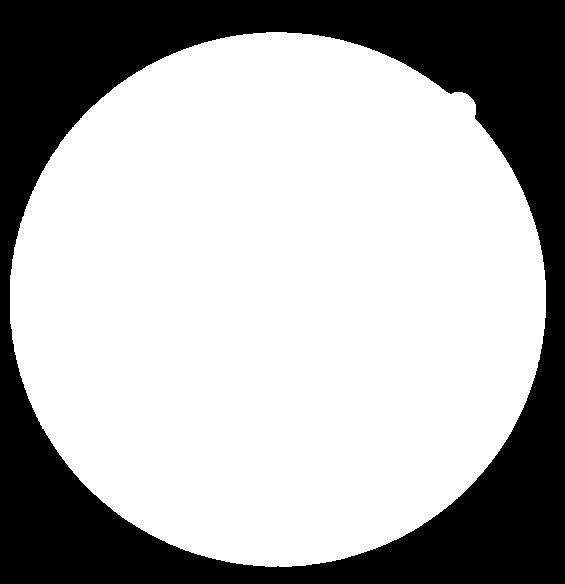

In [11]:
images_dir = x_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
tmp_path = get_screen_path(Path(x_images_paths[0]), screen_train_dir)
im_mask =  Image.open(str(tmp_path))
display(im_mask)

## Making a Map-style dataset

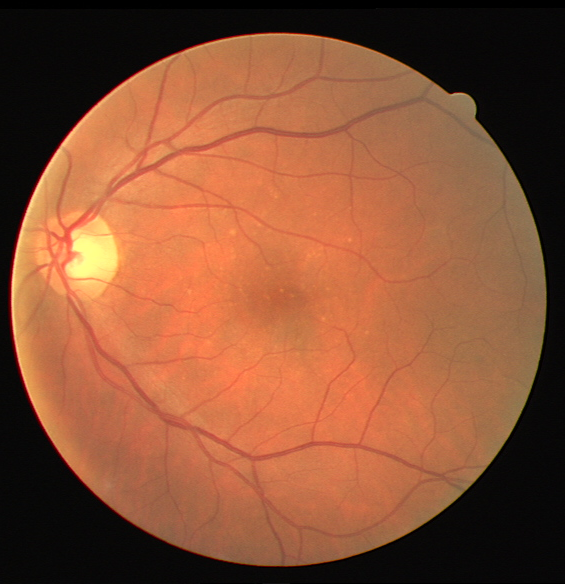

In [12]:
images_dir = x_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
im = Image.open(x_images_paths[0])
display(im)

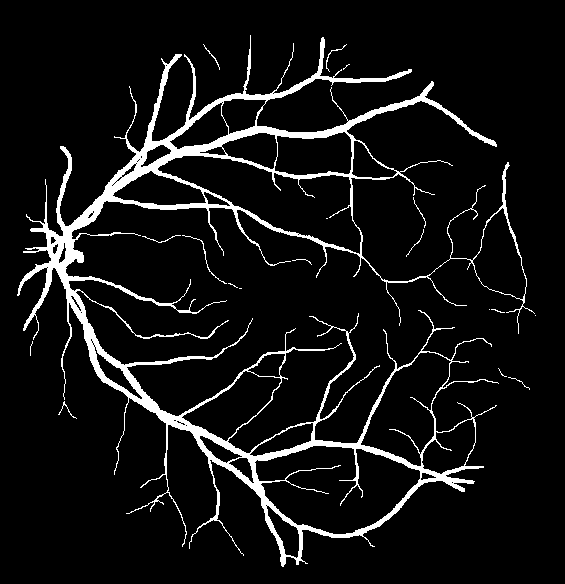

In [42]:
images_dir = x_train_dir
masks_dir = y_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
y_masks_paths = [str(get_mask_path(image_path, masks_dir).absolute()) for 
                         image_path in images_dir.glob('*.tif')]
im = Image.open(y_masks_paths[0])
display(im)
tmp_im = np.array(im)

In [7]:
def get_mask_path(x_image_path, y_train_dir):
    """Get the path of the segmented training file for the path of an original image. \n

    Keyword arguments:
    path -- a pathlib Path to the original data image.

    Output
    SegmentedMaskPath -- a pathlib Path to the matching segmeneted training image. 
    """
    x = x_image_path
    y_ShortFilename = x.stem.replace('training', 'manual1')+ '.gif'
    y_path = y_train_dir/y_ShortFilename
    return y_path

In [8]:
def get_screen_path(x_image_path, screen_dir):
    """Get the path of the segmented training file for the path of an original image. \n

    Keyword arguments:
    path -- a pathlib Path to the original data image.

    Output
    SegmentedMaskPath -- a pathlib Path to the matching segmeneted training image. 
    """
    x = x_image_path
    screen_ShortFilename = x.stem.replace('training', 'training_mask')+ '.gif'
    screen_path = screen_dir/screen_ShortFilename
    return screen_path

In [9]:
def MakeDatasets(images_dir, screen_dir, target_dir, MaxTrainingSetSize = 4, 
                 ValidationFraction = 0.2, size = 640, interpolation = 2):

    x_images_paths = [image_path for image_path in images_dir.glob('*.tif')]
    
    TrainingSetSize = int(min(MaxTrainingSetSize, np.ceil(len(x_images_paths) * (1-ValidationFraction))))
    ValidationSetSize = int(min(len(x_images_paths) - TrainingSetSize, np.ceil(TrainingSetSize * ValidationFraction)) )
    x_images_paths = [x_images_paths[i] for i in np.random.permutation(len(x_images_paths))]

    x_images_paths_train = x_images_paths[:TrainingSetSize]
    x_images_paths_vldt = x_images_paths[TrainingSetSize:TrainingSetSize+ValidationSetSize]

    screen_paths_train = [get_screen_path(Path(image_path), screen_dir) for 
                             image_path in x_images_paths_train]
    screen_paths_vldt = [get_screen_path(Path(image_path), screen_dir) for 
                             image_path in x_images_paths_vldt]

    target_paths_train = [get_mask_path(Path(image_path), target_dir) for 
                             image_path in x_images_paths_train]
    target_paths_vldt = [get_mask_path(Path(image_path), target_dir) for 
                             image_path in x_images_paths_vldt]
    trainDataset = Dataset(x_images_paths_train, screen_paths_train, target_paths_train, 
                           size = size, interpolation = interpolation)
    
    vldtnDataset = Dataset(x_images_paths_vldt, screen_paths_vldt, target_paths_vldt, 
                           size = size, interpolation = interpolation)
    return (trainDataset, vldtnDataset)

In [10]:
class Dataset(BaseDataset):
    CLASSES_pool = ['no','yes']
    def __init__(
                self, 
                image_paths, 
                screen_paths, 
                mask_paths = None, 
                classes= ['yes'], 
                augmentation=None, 
                preprocessing=None,
                size = 640,
                interpolation = 2 # 0 means no interpolation. Mask will remain binary. 
        ):
                
        if not mask_paths:
            self.istest = True
        else:
            self.istest = False
        
        self.ids = [int(file_path.stem[:2]) for file_path in image_paths]
        self.images = [str(image_path.absolute()) for image_path in image_paths]
        self.screens = [str(image_path.absolute()) for image_path in screen_paths]
        
        if mask_paths:
            self.masks = [str(image_path.absolute()) for image_path in mask_paths]
        self.class_values = [self.CLASSES_pool.index(cls.lower()) for cls in classes]
        self.size = size
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.interpolation = interpolation
    
    def __getitem__(self, i):
        # load image, screen and mask (target)
        image = Image.open(self.images[i])
        screen = Image.open(self.screens[i])
        if not self.istest:
            mask =  Image.open(self.masks[i])
        
        # Basic preprocessing:
        Resize = transforms.Resize(self.size, self.interpolation) # the zero is extremely important, or it will change the values
        Flip = torchvision.transforms.RandomHorizontalFlip(p=0.5)
        CenterCrop = transforms.CenterCrop(self.size)
        ToTensor = transforms.ToTensor() # this normalizies to [0,1] range, so must appear before the ImageNet normalization
        Normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        BasicTransforms = list([
                                Resize, 
                                CenterCrop,
                                ToTensor,
                                ])
        ImageTransforms = list([
                                Resize, 
                                CenterCrop,
                                ToTensor,
                                Normalize
        ])
        ImageTransformer = transforms.Compose(ImageTransforms)
        MaskTransformer = transforms.Compose(BasicTransforms)            
        
        image = ImageTransformer(image)
        screen = MaskTransformer(screen)
        # screen = 1.0 - screen # now is zero at sides, 1 at center. 
        if not self.istest:
            mask = MaskTransformer(mask)
        # apply augmentations
        if self.augmentation:
            1;
        
        # apply preprocessing
        if self.preprocessing:
            1;
            
        if self.istest:
            return image, screen
        return image, mask, screen
        
    def __len__(self):
        return len(self.ids)

In [30]:
interpolation = 0
ImageSize = 640 # 320#224 # 
(trainDataset, vldtnDataset) = MakeDatasets(x_train_dir, screen_train_dir, y_train_dir, 
                                            MaxTrainingSetSize = 14, size = ImageSize, interpolation = interpolation)

In [31]:
def visualizeDataset(dataset, UnNormalize = True):
    """PLot images in one row. Only works for one class"""   
    tmp_dataset = dataset
    fig, ax, = plt.subplots(1, 2, figsize = (16,7))
    ind = np.random.randint(0,len(tmp_dataset.ids))
    
    tmp_image_tensor = (tmp_dataset[ind][0]).permute(1,2,0)
    tmp_mask_tensor = np.squeeze((tmp_dataset[ind][1]).permute(1,2,0))
    if UnNormalize:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        ax[0].imshow((tmp_image_tensor * torch.tensor(std)) + torch.tensor(mean))
    else:
        ax[0].imshow(tmp_image_tensor)
    ax[0].set(xticks=(), yticks =(), title = 'Image number ' + str(tmp_dataset.ids[ind])); 
    ax[1].imshow(tmp_mask_tensor, cmap='gray')
    ax[1].set(xticks=(), yticks =()); 

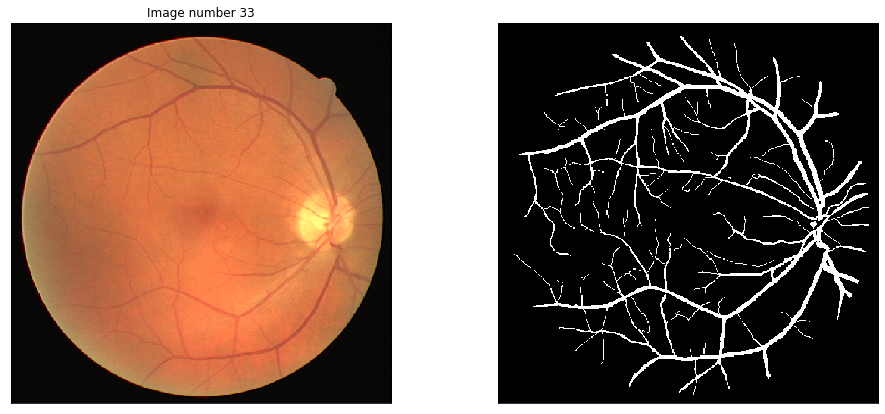

In [32]:
visualizeDataset(trainDataset)

# Create model and train

In [33]:
train_loader = DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
vldtn_loader = DataLoader(dataset = vldtnDataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [34]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )
class UNet(nn.Module):
    """See also https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet"""
    def __init__(self, n_class , freeze = False):
        super().__init__()
        
        self.base_model = models.resnet18()
        ModelPath = Path('/home/jupyter/PretrainedModels')
        machine_OS = platform.system()
        if machine_OS == 'Windows':
            resnetPath = r"C:\Users\M\.torch\models\resnet18-5c106cde.pth"
        elif machine_OS == 'Linux': 
            resnetPath = ModelPath/ 'resnet18-5c106cde.pth'
        
        self.base_model.load_state_dict(torch.load(resnetPath))
        self.base_layers = list(self.base_model.children())
        if freeze: 
            with torch.no_grad():
                self.layer0 = nn.Sequential(*self.base_layers[:3])
        else: 
            self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        
        if freeze: 
            with torch.no_grad():
                self.layer1 = nn.Sequential(*self.base_layers[3:5])
        else: 
            self.layer1 = nn.Sequential(*self.base_layers[3:5])
        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        self.activation = nn.Sigmoid() # MHK added
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x) # -> to size 1
        # maybe add a linear with ReLU here (https://discuss.pytorch.org/t/output-of-sigmoid-last-layer-of-cnn/39757)
#         out_new = self.activation(out) # MHK added
        
        return out

In [35]:
def logSigmoid(tensor):
    # sanity checker. It is a numerically stable implamentation. Does not preserve grad!!!
    eps = 1e-10
    tensor_clone= tensor.detach().clone()
    tensor_clone[tensor>=0] = torch.log(1/ (1+ torch.exp(-tensor[tensor>=0])))
    tensor_clone[tensor<0] = tensor[tensor<0] - torch.log(1+torch.exp(tensor[tensor<0]))
    return tensor_clone
def diceLoss(output, target, screen = None):
    eps = 1e-11
    if isinstance(screen, torch.Tensor):
        Activation = torch.sigmoid(output)* screen
    elif screen == None:
        Activation = torch.sigmoid(output)
    else: 
        print('screen argument type is wrong')
    return 1 - 2 * (Activation * target).sum() / (Activation.sum() + target.sum()) 

In [36]:
del model
torch.cuda.empty_cache()
import gc
gc.collect()

4466

In [37]:
model = UNet(n_class=1).cuda()
criterion = nn.BCEWithLogitsLoss(torch.tensor(20))
# criterion = nn.BCEWithLogitsLoss(weight=torch.tensor(1), reduction='sum')
# criterion = nn.CrossEntropyLoss()

In [38]:
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9)
print(lr)
losses = list()
vldtn_losses = list()
for epoch in range(50): 
    Epoch_losses = list()
    model.train()         
    for ii, (data, target, screen) in enumerate(train_loader):    
        data, target, screen = data.cuda(), target.cuda(), screen.cuda()
        optimizer.zero_grad()
        output = model(data)  
        # loss = criterion(output, target) # for BCE loss.
        loss = diceLoss(output, target)
#         loss = WCE(output, target, weight = 5)
        loss.backward()
        optimizer.step()
        Epoch_losses.append(loss.item())
        if ((np.mod(epoch+1,25) == 0) and (ii == 0)):
            lr = lr/2
            print('New learning rate: ', lr)
            optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9)
#         if loss.item() < 0.6: # this is were dice already removes the mask
#             if lr > 1e-3:
#                 lr = 1e-3
#                 optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9)
#                 print('New learning rate: ', lr)
    losses.append(np.mean(Epoch_losses))
    # run validation
    with torch.no_grad():
        model.eval()
        val_Epoch_losses = list()
        for ii, (data, target, screen) in enumerate(vldtn_loader): 
            data, target, screen = data.cuda(), target.cuda(), screen.cuda()
            output = model(data) 
            val_loss = diceLoss(output, target)
            val_Epoch_losses.append(val_loss.item())     
    vldtn_losses.append(np.mean(val_Epoch_losses))
    print('Epoch: {} - Loss: {:.4f} , Validation: {:.4f}'.format(epoch + 1, 
                                                                 np.mean(Epoch_losses), 
                                                                 np.mean(val_Epoch_losses)))

0.1
Epoch: 1 - Loss: 0.8347 , Validation: 0.7946
Epoch: 2 - Loss: 0.7842 , Validation: 0.7774
Epoch: 3 - Loss: 0.7781 , Validation: 0.7772
Epoch: 4 - Loss: 0.7780 , Validation: 0.7772
Epoch: 5 - Loss: 0.7787 , Validation: 0.7768
Epoch: 6 - Loss: 0.7788 , Validation: 0.7780
Epoch: 7 - Loss: 0.7780 , Validation: 0.7769
Epoch: 8 - Loss: 0.7784 , Validation: 0.7765
Epoch: 9 - Loss: 0.7787 , Validation: 0.7775
Epoch: 10 - Loss: 0.7777 , Validation: 0.7770
Epoch: 11 - Loss: 0.7775 , Validation: 0.7766
Epoch: 12 - Loss: 0.7771 , Validation: 0.7766
Epoch: 13 - Loss: 0.7757 , Validation: 0.7763
Epoch: 14 - Loss: 0.7741 , Validation: 0.7764
Epoch: 15 - Loss: 0.7704 , Validation: 0.7743
Epoch: 16 - Loss: 0.7602 , Validation: 0.7502
Epoch: 17 - Loss: 0.7259 , Validation: 0.7334
Epoch: 18 - Loss: 0.7300 , Validation: 0.7810
Epoch: 19 - Loss: 0.7121 , Validation: 0.7849
Epoch: 20 - Loss: 0.7160 , Validation: 0.7480
Epoch: 21 - Loss: 0.7064 , Validation: 0.7144
Epoch: 22 - Loss: 0.6940 , Validation: 

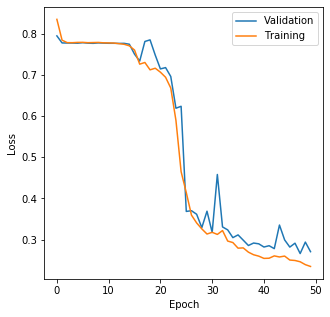

In [39]:
fig, ax = plt.subplots(1, figsize = (5,5))
ax.plot(vldtn_losses, label = 'Validation')
ax.plot(losses, label = 'Training')
ax.legend();
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

In [40]:
lr = 0.025
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9)
print(lr)
losses = list()
vldtn_losses = list()
for epoch in range(50): 
    Epoch_losses = list()
    model.train()         
    for ii, (data, target, screen) in enumerate(train_loader):    
        data, target, screen = data.cuda(), target.cuda(), screen.cuda()
        optimizer.zero_grad()
        output = model(data)  
        # loss = criterion(output, target) # for BCE loss.
        loss = diceLoss(output, target)
#         loss = WCE(output, target, weight = 5)
        loss.backward()
        optimizer.step()
        Epoch_losses.append(loss.item())
        if ((np.mod(epoch+1,25) == 0) and (ii == 0)):
            lr = lr/2
            print('New learning rate: ', lr)
            optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9)
#         if loss.item() < 0.6: # this is were dice already removes the mask
#             if lr > 1e-3:
#                 lr = 1e-3
#                 optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9)
#                 print('New learning rate: ', lr)
    losses.append(np.mean(Epoch_losses))
    # run validation
    with torch.no_grad():
        model.eval()
        val_Epoch_losses = list()
        for ii, (data, target, screen) in enumerate(vldtn_loader): 
            data, target, screen = data.cuda(), target.cuda(), screen.cuda()
            output = model(data) 
            val_loss = diceLoss(output, target)
            val_Epoch_losses.append(val_loss.item())     
    vldtn_losses.append(np.mean(val_Epoch_losses))
    print('Epoch: {} - Loss: {:.4f} , Validation: {:.4f}'.format(epoch + 1, 
                                                                 np.mean(Epoch_losses), 
                                                                 np.mean(val_Epoch_losses)))

0.025
Epoch: 1 - Loss: 0.2310 , Validation: 0.2715
Epoch: 2 - Loss: 0.2293 , Validation: 0.2710
Epoch: 3 - Loss: 0.2273 , Validation: 0.2679
Epoch: 4 - Loss: 0.2258 , Validation: 0.2730
Epoch: 5 - Loss: 0.2242 , Validation: 0.2680
Epoch: 6 - Loss: 0.2230 , Validation: 0.2727
Epoch: 7 - Loss: 0.2216 , Validation: 0.2668
Epoch: 8 - Loss: 0.2210 , Validation: 0.2718
Epoch: 9 - Loss: 0.2195 , Validation: 0.2730
Epoch: 10 - Loss: 0.2180 , Validation: 0.2709
Epoch: 11 - Loss: 0.2168 , Validation: 0.2713
Epoch: 12 - Loss: 0.2166 , Validation: 0.2632
Epoch: 13 - Loss: 0.2158 , Validation: 0.2685
Epoch: 14 - Loss: 0.2143 , Validation: 0.2795
Epoch: 15 - Loss: 0.2143 , Validation: 0.2749
Epoch: 16 - Loss: 0.2177 , Validation: 0.2595
Epoch: 17 - Loss: 0.2170 , Validation: 0.2684
Epoch: 18 - Loss: 0.2137 , Validation: 0.2640
Epoch: 19 - Loss: 0.2106 , Validation: 0.2637
Epoch: 20 - Loss: 0.2101 , Validation: 0.2664
Epoch: 21 - Loss: 0.2092 , Validation: 0.2677
Epoch: 22 - Loss: 0.2073 , Validation

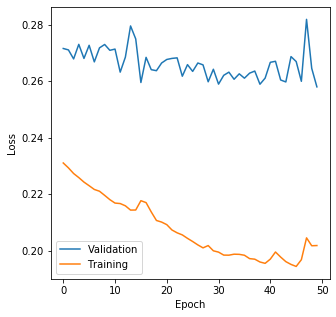

In [41]:
fig, ax = plt.subplots(1, figsize = (5,5))
ax.plot(vldtn_losses, label = 'Validation')
ax.plot(losses, label = 'Training')
ax.legend();
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

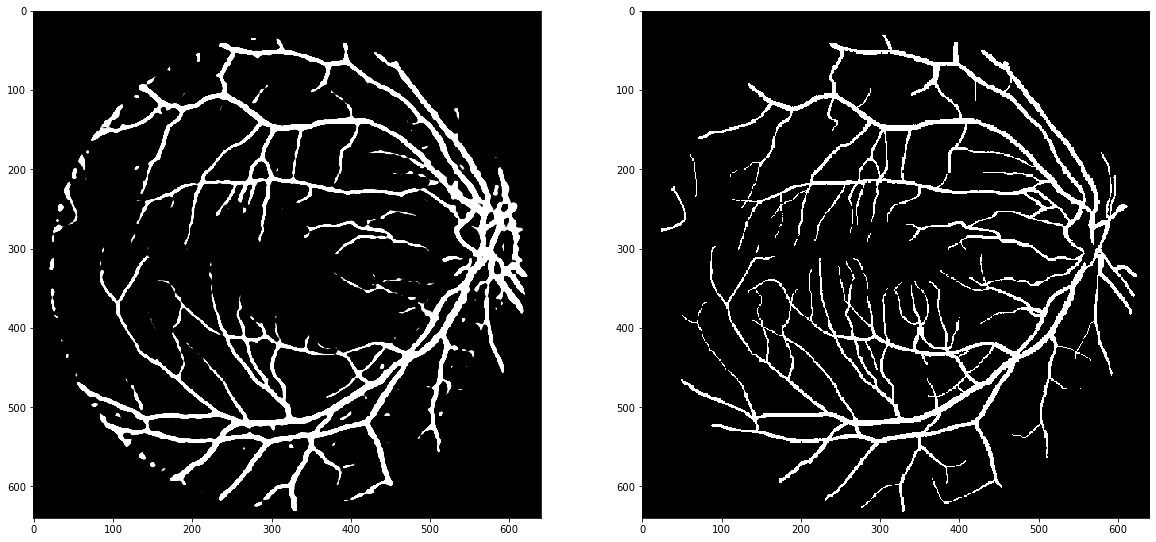

In [42]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
with torch.no_grad():
    predicted = torch.sigmoid(output[0,0,:,:]).cpu().detach().numpy()
    t_array = target[0,0,:,:].cpu().detach().numpy()
    ax[0].imshow(predicted, cmap = 'gray')
    ax[1].imshow(t_array, cmap = 'gray')

In [43]:
torch.save(model, str(BaseFolder / 'Model640NoIntrpl_dice_100Epochs.pth'))

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__nam

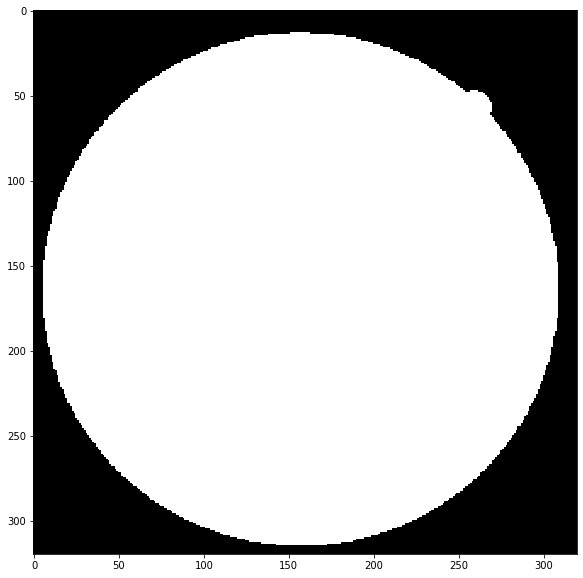

In [23]:
plt.figure(figsize=(10,10))
if batch_size>1: 
#     plt.imshow(output[0].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.imshow(screen[0].squeeze().cpu().detach().numpy(), cmap='gray')
else: 
    plt.imshow(output[0].squeeze().cpu().detach().numpy(), cmap='gray')
# plt.imshow(screen.squeeze().cpu().detach().numpy(), cmap='gray')

In [40]:
torch.save(model, str(BaseFolder / 'Model320NoIntrpl_dice_200Epochs.pth'))

/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
# torch.save(model, str(BaseFolder / 'Model320Bilinear.pth'))

In [29]:
x_test_dir = DataFolder/'test'/'images'

In [41]:
test_dataset = Dataset(
    x_train_dir, 
    screen_train_dir,
    classes=['yes'],
)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


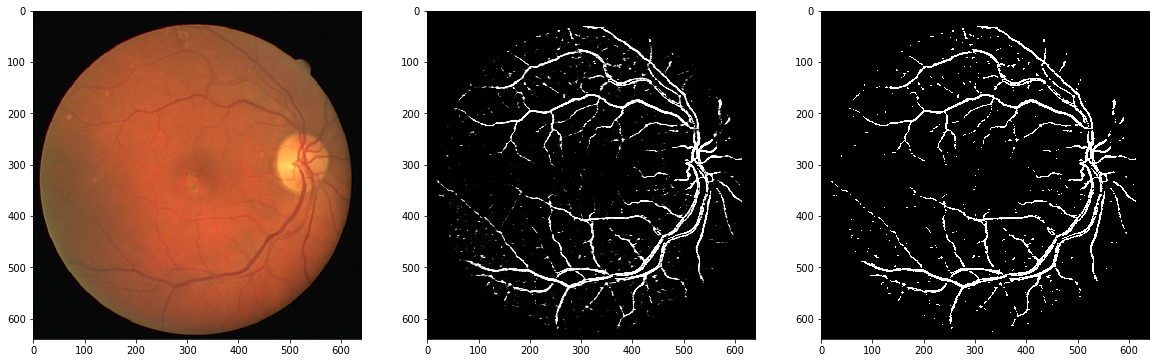

In [42]:
ind = 4
with torch.no_grad():
    fig, ax = plt.subplots(1,3, figsize = (20,8))

    x = test_dataset[ind][0].unsqueeze(0)
    o = model(x.cuda())
    original_image = x.cpu().detach().numpy()
    original_image = np.transpose(original_image[0], axes = [1,2,0])
    original_image = original_image * std + mean
    output_image = o.cpu().detach().numpy() 
    output_image = np.squeeze(output_image)
    output_image = 1/(1 + np.exp(-output_image)) 
    # mn = np.mean(output_image)*5
    mn = 0.5
    output_image_thresh = np.copy(output_image)
    output_image_thresh[output_image<mn] = 0
    output_image_thresh[output_image>mn] = 1
    ax[0].imshow(original_image)
    ax[1].imshow(output_image, cmap = 'gray')
    ax[2].imshow(output_image_thresh, cmap = 'gray')

TypeError: Invalid shape (2, 480, 480) for image data

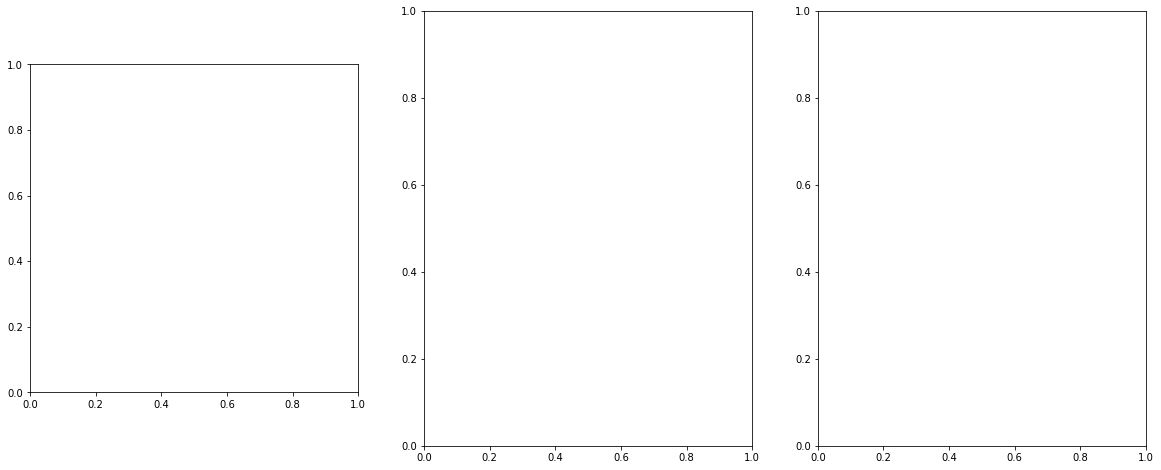

In [131]:
# if training over one bs = 1
fig, ax = plt.subplots(1,3, figsize = (20,8))
# x = augmented_dataset[0][0].unsqueeze(0)
# o = model(x.cuda())  
# tmp2 = o.cpu().detach().numpy() * (-1)
tmp2 = output.cpu().detach().numpy() 
tmp = np.copy(tmp2)
tmp3 = np.copy(tmp2)
mn = np.mean(tmp)*0.05
tmp3[tmp<mn] = 0
tmp3[tmp>mn] = 1
ax[0].imshow(np.squeeze(tmp3), cmap = 'binary_r')

target_numpy = target.cpu().detach().numpy()
ax[1].imshow(np.squeeze(target_numpy), cmap = 'binary_r')
ax[2].imshow(np.squeeze(tmp2), cmap = 'binary_r')

## Not figuring out things with loss functions

In [605]:
def WCE(output, target, weight = torch.tensor(1)):
    """My custom WEIGHTED Cross Entropy loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,inf]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    identical to: 
    nn.BCEWithLogitsLoss(weight=torch.tensor(1), reduction='sum')"""
    output_clone = output.detach().clone()
    eps=torch.tensor(1e-21)
    return -(weight * target * F.logsigmoid(output_clone) + (1-target) * F.logsigmoid(1 - output_clone)).sum()
    # return -(weight * target * logSigmoid(output) + (1-target) * logSigmoid(1 - output)).sum()

In [604]:
def focal_loss(output, target, weight = torch.tensor(1)):
    """My custom Focal loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,1]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    See Lar's Blog on losses. 
    """
    

In [603]:
def BCE(output, target, weight = torch.tensor(1)):
    """My custom Balanced Cross Entropy loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,1]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    """
    eps=0
    output_clone = output.detach().clone()
    # output_clone = Sigmoid(output_clone)
    return -(weight * target * F.logsigmoid(output_clone + eps) +  (1-weight) * (1-target) * F.logsigmoid(1 - output_clone + eps)).sum()

In [632]:
weight = torch.tensor(1)
output = 1* torch.randn(3)
target = torch.empty(3).random_(2)
criterion = nn.BCEWithLogitsLoss(weight=weight, reduction='sum')
print(criterion(output, target))
print(WCE(output, target, weight = weight))
print(binary_cross_entropy_with_logits(output, target, weight=weight, reduction='sum'))
print(output, target)

tensor(2.0488)
tensor(1.6132)
tensor(2.0488)
tensor([-0.9652, -0.2209, -1.6723]) tensor([1., 0., 0.])


In [376]:
from torch.nn.functional import binary_cross_entropy_with_logits

In [ ]:
binary_cross_entropy_with_logits()

tensor(1.0091)